In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# libraries for formating , cleaning and treatment of the datasets
import pandas as pd
import numpy as np
import collections
import itertools
# libraries for run neural network with keras and tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import MaxPooling2D,  BatchNormalization,  GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam, SGD, Adamax


from sklearn.metrics import confusion_matrix
from sklearn import metrics
import tensorflow as tf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers

# libraries to graph the models results 
import matplotlib
import matplotlib.pyplot as plt

# Rezise image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io

In [0]:
# declaration of functions to graph the dataset images 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrix de Confusion',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Original')
    plt.xlabel('Predicciones')


def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

In [0]:
# Using the library pandas you can import the file csv
dataset_facial_expression = pd.read_csv("/content/gdrive/My Drive/fer2013.csv")

In [7]:
# display the top five
dataset_facial_expression.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
# display the last five
dataset_facial_expression.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [9]:
# Summary statistics: Numeric data
dataset_facial_expression.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [10]:
type(dataset_facial_expression)

pandas.core.frame.DataFrame

In [11]:
dataset_facial_expression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


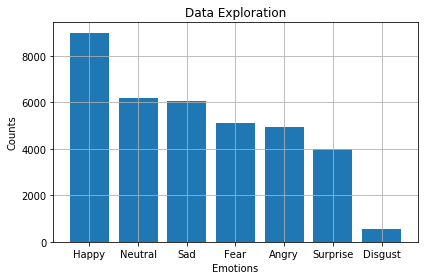

,emotion,count
3,Happy,8989
6,Neutral,6198
4,Sad,6077
2,Fear,5121
0,Angry,4953
5,Surprise,4002
1,Disgust,547


In [12]:
delais_emotion_label = ("Happy", "Neutral", "Sad",
                        "Fear", "Angry", "Surprise", "Disgust")
delais_emotion = pd.DataFrame(data=dataset_facial_expression["emotion"]
                              .value_counts())
delais_emotion["count"] = delais_emotion["emotion"]
delais_emotion["emotion"] = delais_emotion_label
delais_emotion

%matplotlib inline
fig, ax = plt.subplots()
ax.bar(delais_emotion["emotion"], delais_emotion["count"])
ax.set_title("Data Exploration")
ax.set_ylabel("Counts")
ax.set_xlabel("Emotions")
ax.grid()
fig.tight_layout()
plt.show()
delais_emotion

In [0]:
# A loop starts for matrix with correct dimension for the model
y = np.zeros((35887, 48, 48))
for i in range(35887):
    imagen = dataset_facial_expression["pixels"][0+i]
    imagen_list_pixel = imagen.split(" ")
    imagen_array_pixel = np.asarray(imagen_list_pixel, dtype=float)
    imagen_rezise_pixel = imagen_array_pixel.reshape(-1, 48, 48)
    y[i] = y[i]+imagen_rezise_pixel[0]

In [14]:
# it is checked how many types of labels there are in which set
train_labels = np.array(dataset_facial_expression["emotion"][:28710])
test_labels = np.array(dataset_facial_expression["emotion"][28711:32299])
validation_labels = np.array(dataset_facial_expression["emotion"][32300:])

print("Validation Labels = " + str(collections.Counter(validation_labels)))
print("Test Labels = " + str(collections.Counter(test_labels)))
print("Train Labels = " + str(collections.Counter(train_labels)))


Validation Labels = Counter({3: 879, 6: 626, 4: 594, 2: 528, 0: 490, 5: 415, 1: 55})
Test Labels = Counter({3: 895, 4: 653, 6: 607, 2: 496, 0: 467, 5: 415, 1: 55})
Train Labels = Counter({3: 7215, 6: 4965, 4: 4830, 2: 4097, 0: 3996, 5: 3171, 1: 436})


In [0]:
# it is divided the dataset for the training
train_images = y[:28710]
train_labels = np.array(dataset_facial_expression["emotion"][:28710])
test_images = y[28711:]
test_images2 = y[28711:]
test_labels = np.array(dataset_facial_expression["emotion"][28711:])
test_labels2 = np.array(dataset_facial_expression["emotion"][28711:])
validation_images = y[32300:]
validation_labels = np.array(dataset_facial_expression["emotion"][32300:])
train_images = train_images.astype("float32")
test_images = test_images.astype("float32")
train_images /= 255
test_images /= 255

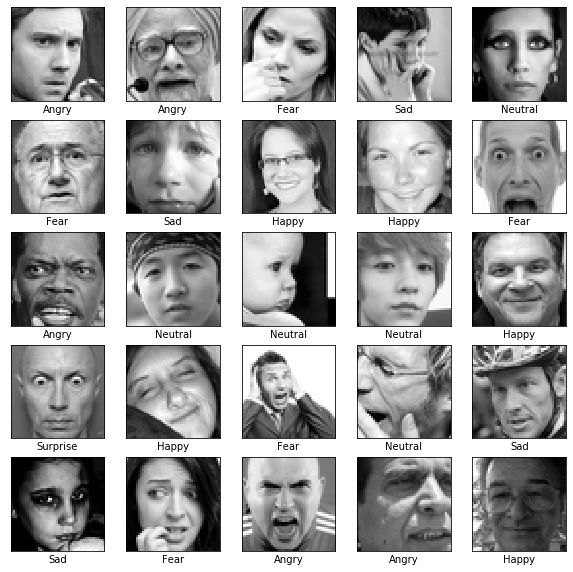

In [16]:
class_names = ["Angry", "Disgust", "Fear",
               "Happy", "Sad", "Surprise", "Neutral"]
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap="gray")
    plt.xlabel(class_names[train_labels[i]])

In [17]:
# the variables is initialized
input_shape = (48, 48, 1)
batch_size = 128
num_classes = 7
epochs = 10
# convert class vectors to binary class matrices
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)
validation_labels = keras.utils.to_categorical(validation_labels, num_classes)
# Reshape the training and test set
train_images = train_images.reshape(28710, 2304)
test_images = test_images.reshape(7176, 2304)
train_images = train_images.reshape(train_images.shape[0], 48, 48, 1)
test_images = test_images.reshape(test_images.shape[0], 48, 48, 1)
# Setup the layers
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.6))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         


In [0]:
MAP_CHARACTERS = {0: "Angry", 1: "Disgust", 2: "Fear",
                  3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
opt = Adamax(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)

datagen.fit(train_images)

history = model.fit_generator(datagen.flow(train_images, train_labels,
                              batch_size=batch_size),
                              steps_per_epoch=20 *
                              (len(train_images) / batch_size),
                              epochs=epochs, validation_data=(test_images,
                              test_labels),
                              nb_val_samples=0.2)


# Evaluate Model
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(test_images, test_labels, verbose=0)
print('\nKeras CNN #3B - accuracy:', score[1])
print('')
# Make predictions
y_pred = model.predict(test_images)
print('\n', metrics.classification_report(np.where(test_labels > 0)[1],
                                          np.argmax(y_pred, axis=1),
                                          target_names=list
                                          (MAP_CHARACTERS.values())), sep='')
Y_pred_classes = np.argmax(y_pred, axis=1)
Y_true = np.argmax(test_labels, axis=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=4485.9375, epochs=10, validation_data=(array([[[..., validation_steps=0.2)`





Epoch 1/10





4486/4485 [==============================] - 13290s 3s/step - loss: 1.6934 - acc: 0.3212 - val_loss: 1.4697 - val_acc: 0.4363
Epoch 2/10
4486/4485 [==============================] - 13203s 3s/step - loss: 1.4531 - acc: 0.4400 - val_loss: 1.2877 - val_acc: 0.5054
Epoch 3/10
4486/4485 [==============================] - 13199s 3s/step - loss: 1.3154 - acc: 0.4971 - val_loss: 1.1682 - val_acc: 0.5543
Epoch 4/10
1040/4485 [=====>........................] - ETA: 2:49:34 - loss: 1.2516 - acc: 0.5231